# Fall 2025 - Assignment 1

* Geoffroy Hébert-Emond - 11273505
* Loubna Naciri - 11258155

# Context

We are going to consider the most liquid options traded on Apple on two particular business days of 2020: January 17 and March 20. The next couple of code cells were used to generate the dataset by connecting to OptionMetrics. With `GENERATE = False`, they simply load the dataset as saved to disk.

In [16]:
# The following import allow absolute imports scripts within the dorion_francois package
#import internal_script

import datetime as dt
import os
import sys
import numpy as np
import pandas as pd
import pickle
import importlib

##############################################################################
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.image as mpimg

In [17]:
def filters(options):
    """These filters were applied to the data"""
    # Options before maturity
    options = options.loc[options.date < options.exdate].reset_index()

    # Positive open interest
    options = options[options['open_interest'] > 0]

    # Abs(delta) between 0.01 and 0.99
    options = options[(options['delta'].abs() >= 0.01) & (options['delta'].abs() <= 0.99)]

    # Implied vol between 0.03 and 2
    options = options[(options['impl_volatility'] >= 0.03) & (options['impl_volatility'] <= 2)]

    # Bid price is greater than 0.1 and less than ask price
    options = options[(options['best_offer'] > options['best_bid']) & (options['best_bid'] > 0.1)]

    return options

GENERATE = False
if GENERATE:
    import dorion_francois.option_metrics as om
    jan17 = om.get_option_data(101594, dt.date(2020,1,17))
    mar20 = om.get_option_data(101594, dt.date(2020,3,20))
    options = filters( pd.concat((jan17,mar20),axis=0) )
    with open('202510-assignment1.pkl','wb') as fh:
        # OptionMetrics 'strike_price' column is the strike x1000. We'll drop it to avoid confusion; use the 'strike' column
        pickle.dump(options.drop(columns=['strike_price']),fh)
else:
    with open('202510-assignment1.pkl','rb') as fh:
        options = pickle.load(fh)
options.describe()

,index,secid,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,...,option_price,DTM,YTM,risk_free,stock_price,stock_exdiv,implied_forward_price,implied_vol_bms,implied_vol_bid,implied_vol_ask
count,3041.000000,3041.0,3041.0,3041.0,3041.0,3041.0,3041.000000,3041.0,3041.0,3041.0,...,3041.0,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000,3039.000000,2907.000000,3041.000000
mean,1290.575469,101594.0,39.54265,41.070812,302.719171,1493.480434,0.486984,0.051175,0.004216,43.996647,...,40.306731,247.602105,0.678362,0.011057,267.849300,266.408353,268.266957,0.491364,0.463369,0.517211
std,588.418749,0.0,47.505847,48.379765,1413.149222,2810.188475,0.246677,0.573104,0.00421,39.878651,...,47.939597,256.838994,0.703668,0.005106,44.329611,44.126488,45.364910,0.240483,0.227888,0.264064
min,166.000000,101594.0,0.11,0.14,0.0,1.0,0.209335,-0.989916,0.00004,0.264909,...,0.13,7.000000,0.019178,0.004597,229.240000,226.093746,227.456884,0.209760,0.004413,0.211192
25%,805.000000,101594.0,3.85,4.75,0.0,76.0,0.308580,-0.332122,0.001665,13.6014,...,4.25,35.000000,0.095890,0.006167,229.240000,227.603325,228.595023,0.313801,0.290405,0.324194
50%,1334.000000,101594.0,20.05,21.5,14.0,383.0,0.407585,0.02422,0.003027,29.80537,...,20.8,154.000000,0.421918,0.008564,229.240000,229.240000,229.774853,0.414581,0.389198,0.437239
75%,1800.000000,101594.0,60.75,63.0,97.0,1594.0,0.593389,0.526664,0.005168,64.20898,...,61.75,455.000000,1.246575,0.016588,318.730000,317.145554,319.221626,0.603811,0.573138,0.637671
max,2345.000000,101594.0,271.0,275.5,29443.0,28015.0,1.998797,0.989859,0.042843,193.543,...,273.25,882.000000,2.416438,0.017424,318.730000,318.730000,325.069560,1.656574,1.601841,2.527934


# Question 1

Create a scatter plot with the risk-free rate (`100*options.risk_free`) against the time to maturity expressed in years (`options.YTM`). Discuss the figure. Given that the Black-Merton-Scholes economy assumes that the risk-free rate is constant, should one still account for the variation it illustrates if pricing options with the model? Why?

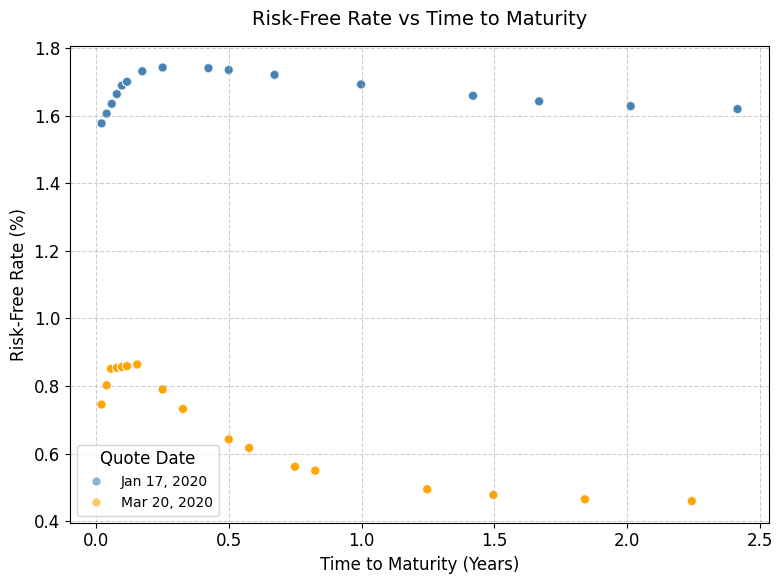

In [18]:
# CODE QUESTION 1 

df = options[['YTM', 'risk_free', 'date']].dropna().copy()

df['quote_date'] = pd.to_datetime(df['date']).dt.normalize().map({
    pd.Timestamp('2020-01-17'): 'Jan 17, 2020',
    pd.Timestamp('2020-03-20'): 'Mar 20, 2020'
})

df = df[df['quote_date'].notna()]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='YTM',
    y=100 * df['risk_free'],
    hue='quote_date',
    palette={'Jan 17, 2020': 'steelblue', 'Mar 20, 2020': 'orange'},
    alpha=0.6,
    s=40
)

plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Risk-Free Rate (%)")
plt.title("Risk-Free Rate vs Time to Maturity", pad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Quote Date")
plt.tight_layout()
plt.show()

As we can observe, rates dropped sharply from January to March 2020.
For the Jan 17th quote date, the curve sits higher than the March 2020 curve (orange).
The lower post-COVID curve (March 2020) reflects the Federal Reserve’s emergency rate cuts and the flight to safety that followed the market turmoil. Investors rushed into short-term Treasury bills and government bonds, pushing yields sharply lower across all maturities. The short end dropped the most as the Fed slashed policy rates close to zero, while long-term rates also fell due to expectations of a prolonged period of low growth and low inflation.
The downward-sloping curve is consistent with economic intuition. Investors required higher short-term rates in early 2020 because monetary policy had not yet adjusted to the coming slowdown, while long-term rates were lower as markets anticipated future rate cuts and weaker growth.
Even in January 2020, before the COVID-19 shock, the yield curve was already relatively flat or slightly downward-sloping. This was consistent with the economic context: markets were expecting further monetary easing and slower long-term growth following several Fed rate cuts in 2019.
Therefore, even pre-COVID, investors demanded lower long-term rates, anticipating a softening economy and lower inflation. In other words, investors accepted lower yields for long maturities because they expected the economy and interest rates to decline in the future. This shape thus reflects rational expectations and is typical before recessions or during periods of anticipated monetary easing.
We can also see more unevenness on the short end of the curve in March (COVID stress period). The variation observed in the rate across maturities is consistent with the BMS model, which assumes a constant rate per option, not across all maturities. Using maturity-appropriate rates is therefore necessary to avoid mispricing options.

# Question 2
Similarly, scatter `options.stock - options.stock_exdiv`, where the former is the stock price and the latter accounts for the dividends **actually** paid over the life of the options.

Discuss the figure. Can we conclude that Apple changed its dividend policy between the two dates? Describe which variation of the Black-Merton-Scholes formula seen in class could be used to price the options on Apple if they were European options. Support your discussion with succinct mathematical expressions and/or derivations, in which you can focus on the calls without loss of generality.

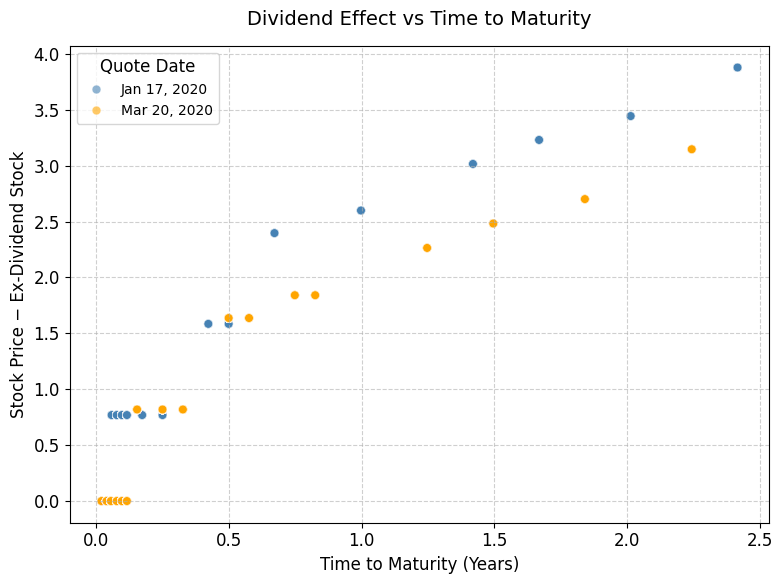

In [19]:
# CODE QUESTION 2

df = options[['YTM', 'stock_price', 'stock_exdiv', 'date']].dropna().copy()
df['div_eff'] = df['stock_price'] - df['stock_exdiv']


df['quote_date'] = pd.to_datetime(df['date']).dt.normalize().map({
    pd.Timestamp('2020-01-17'): 'Jan 17, 2020',
    pd.Timestamp('2020-03-20'): 'Mar 20, 2020'
})

df = df[df['quote_date'].notna()]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='YTM',
    y='div_eff',
    hue='quote_date',
    palette={'Jan 17, 2020': 'steelblue', 'Mar 20, 2020': 'orange'},
    alpha=0.6,
    s=40
)

plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Stock Price − Ex-Dividend Stock")
plt.title("Dividend Effect vs Time to Maturity", pad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Quote Date")
plt.tight_layout()
plt.show()


As the plot shows, the present value of dividends paid before option expiry increases with maturity. This is consistent with expectations: the longer the horizon, the more dividend payments occur during the option’s life. The January curve lies consistently above the March curve for the same maturities, particularly beyond 1.5 years.
The gap between both curves does not indicate any change in Apple’s dividend policy. Between January and March, one quarterly dividend payment occurred, explaining the lower March curve. For the same remaining maturities, there are simply fewer dividends left to be paid during the option’s life, which mechanically reduces the difference between S and S_ex-div.

As we can observe the dividends are known (to an extent) and discrete, thus we can use a modified version of the BS model that allows dividend. Indeed, we need to use a modified version of the standard framework as each dividend payment will cause the stock price to drop by a known amount on the ex-dividend date, breaking the "continuous geometric Brownian motion" assumption that is required for the standard BMS to work. To handle this issue, we can adjust the stock price to its ex-dividend level by removing the present value of all future dividends before maturity.


### European Options with Known Discrete Dividends

As mentionned earlier, when a stock pays known cash dividends before maturity $T$, the standard BMS model must be adjusted. Each dividend payment causes a predictable price drop in the underlying asset. With an ex-dividend date $t_1$, the price of the stock right after the dividend payment satisfies:

$$ S(t_1^+) = S(t_1^-) - d(t_1) $$

### Ex-Dividend Adjustment

The present value of expected dividends between $t$ and $T$ is:

$$ I(t,T) = \sum_{t < t_i \le T} d(t_i)\, e^{-r (t_i - t)} $$

The adjusted underlying is:

$$ \hat{S}(t,T) = S(t) - I(t,T) $$

### BMS Pricing Formula, Adjusted for Discrete Dividends

Under risk-neutral valuation, the adjusted European call price is:

$$ c_t = \hat{S}(t,T) N(d_1) - K e^{-r\tau} N(d_2) $$

where $\tau = T - t$ and  

$$ d_{1,2} = \frac{\ln(\hat{S}(t,T)/K) + (r \pm \tfrac{1}{2}\sigma^2)\tau}{\sigma \sqrt{\tau}} $$



### Put–Call Parity

Furthermore, we can get the following updated relation for the put call parity.

$$ c_t - p_t = S_t - I(t,T) - K e^{-r\tau}
             = \hat{S}(t,T) - K e^{-r\tau} $$


Based on the litterature (Beneder & Vorst, 2001) and the class notes we can establish that for short maturities (under one year), this approach is realistic and also widely used in equity option pricing.

# Question 3
Implement a function that inverts this variation of the BSM formula to obtain the BMS implied volatility for each of the options in the dataframe. Define moneyness as $M = K / \hat{S}_t$ and focus on out-of-the-money (OTM) options ($M \le 1$ puts, $M > 1$ calls). Create a dataframe `otm_options` containing only those options and add a column with the result of your IV calculation for each option therein.

In a 1x2 figure, scatter your results, with  on the x-axis, against a line plot for `implied_vol_bms`: In the left (right) panel, use options quoted on Jan 17 and expiring on Feb 14 (July 17), 2020, and options quoted on Mar 20 expiring on April 17 (Oct. 16), 2020. On each panel, you should thus have 2 lines with your results scattered atop them. Discuss this figure: how does the level and span (across moneyness) of the smiles vary, compare across maturities, etc. Given your discussion, can you suggest a better measure for moneyness? If you generate anew the previous figure using this alternate moneyness measure, how does it impact your analysis of the figure?

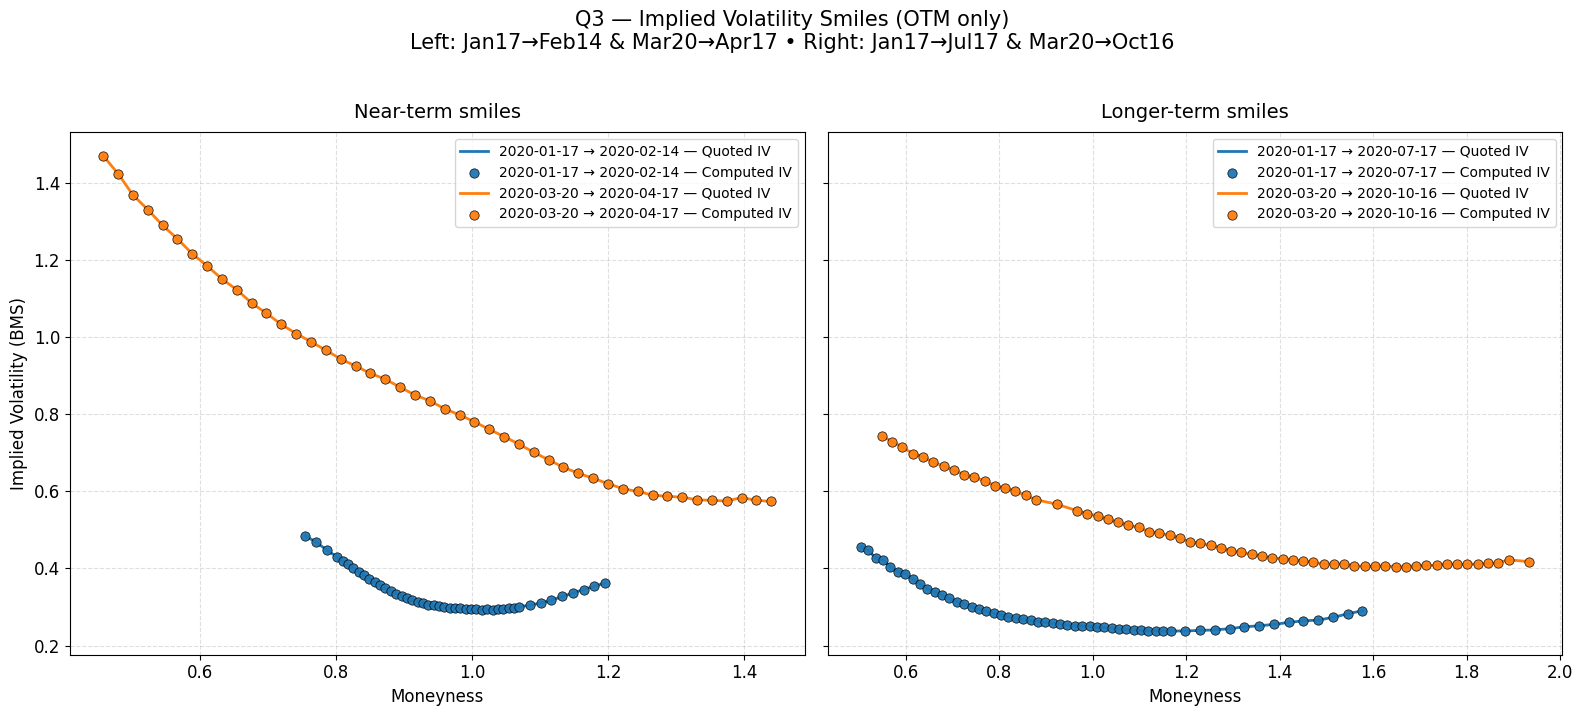

In [20]:
#QUESTION 3

import q3_a as q3a
otm_options = q3a.build_otm_options(options)
q3a.plot_q3_smiles(otm_options)

The output graphs, which show implied volatility against the K/S ratio (moneyness) exhibit a "smile" or "skew," meaning that options with different strikes can have significantly different implied volatilities. When volatility is not constant, implied volatilities can vary with strike prices, creating a "smile" or "skew,". The BMS model's assumption of constat volatility fails to capture this phenomenon. This deviation from a flat smile  (assumed bu the model) highlights the model's limitations in capturing underlying asset price dynamics. The inability to account for the observed smile or skew in implied volatility can result in mispricing of options, especially for those that are far out-of-the-money or deep in-the-money.

We can observe that the march curves (orange) are positionned significantly higher than those of the month of january. This is observable across both panels.
This is consitent with what we would expect as a market behaviour during market conditions like the COVID-19 market crash we observed in march 2020. There is a massive spike in implied volatility (a forward looking measure) which represents the market's consensus on future risk.  The higher levels of IV shown by the orange curves indicate investors pricing in a much more uncertain market and expecting larger price swings.

For the pre-COVID period, both near-teram and long-term maturities display a gentle U shaped IV, with slightly higher IVs for deep OTM puts (M<1) and OTM calls (M>1) and minimum IVs observed at moneyness around 1 (ATM for both).

On the other hand, for the crisis period, the U shape becomes steeper for lower levels of moneyness (M<1).
As we can interpret, OTM puts exhibited a volatility skew, which would be consistent with the logic that they were more in demand (for downside protection). This observation is more visible in the Short-end panel, due to the fact that shorter maturities are more sensitive to shocks and respond more strongly.
Longer maturities (right pannel) exhibit flatter and smaller skews, consistent with the idea that volatility expectations tend to smooth out over time.

On a broader level, We can also comment that the term structure for longer maturities for the pre-crisis period exhibit normal behaviour; (lower overall IV levels on the right pannel vs the left pannel for the January quoted options). This shows a behaviour consistent with normal upward sloping volatility term structure.

For the March quoted, shorter maturities show even higher IVs.

We used a plain moneyness ratio for this analysis. However, this raw moneyness measure does not account for interest rates, dividends or time to maturity. An alternative could be the log-forward moneyness ratio s.t : M = ln(K/F(t)) with F(t) = S(t) e {r-y}T , where F(t) is the forward price with risk-free rate r and dividend yield y).

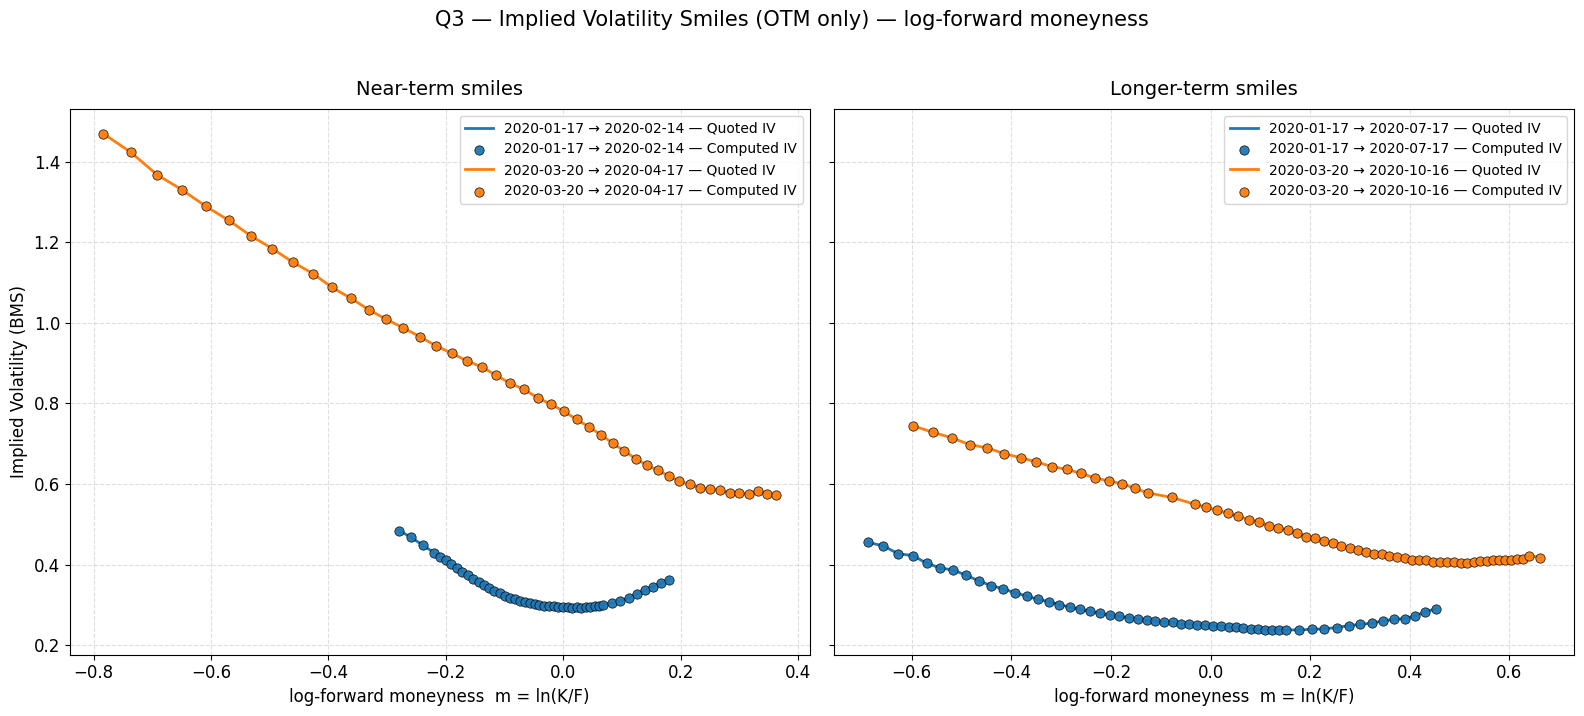

In [21]:
#QUESTION 3 B
import q3_a as q3a
import q3_b as q3b

otm_options = q3a.build_otm_options(options)

q3b.replot_log_forward(otm_options)

Using the log forward moneyness measure gets rid of the carry/yield/dividend induced effects/changes, which results in more accurate smiles. These smiles are centered around 0 (with ATM re-anchored at M=0).
Even after this adjustment, the overall conclusions remain unchanged: the level of implied volatility and the skew patterns across quote dates, maturities, and moneyness persist, confirming that the observed differences are structural rather than due to the choice of moneyness measure.

# Question 4

Consider the same OTM options as in the previous question. We now want to scatter
\begin{equation}
    100 \left(\frac{ \text{'impl\_volatility'} }{ \text{'implied\_vol\_bms'} } - 1\right)
\end{equation}
against moneyness (the version you feel most comfortable with). The 'impl_volatility' column provides an implied volatility measure as computed by the data provider using a proprietary algorithm. How should the y-axis be interpreted? Are the magnitudes relatively large or small? Would we obtain the same result comparing CRR and BMS implied volatilities for the in-the-money (ITM) options?

(<Figure size 1400x600 with 2 Axes>,
 array([<Axes: title={'center': 'Jan 17, 2020'}, xlabel='Moneyness', ylabel='IV Difference (%)'>,
        <Axes: title={'center': 'Mar 20, 2020'}, xlabel='Moneyness'>],
       dtype=object))

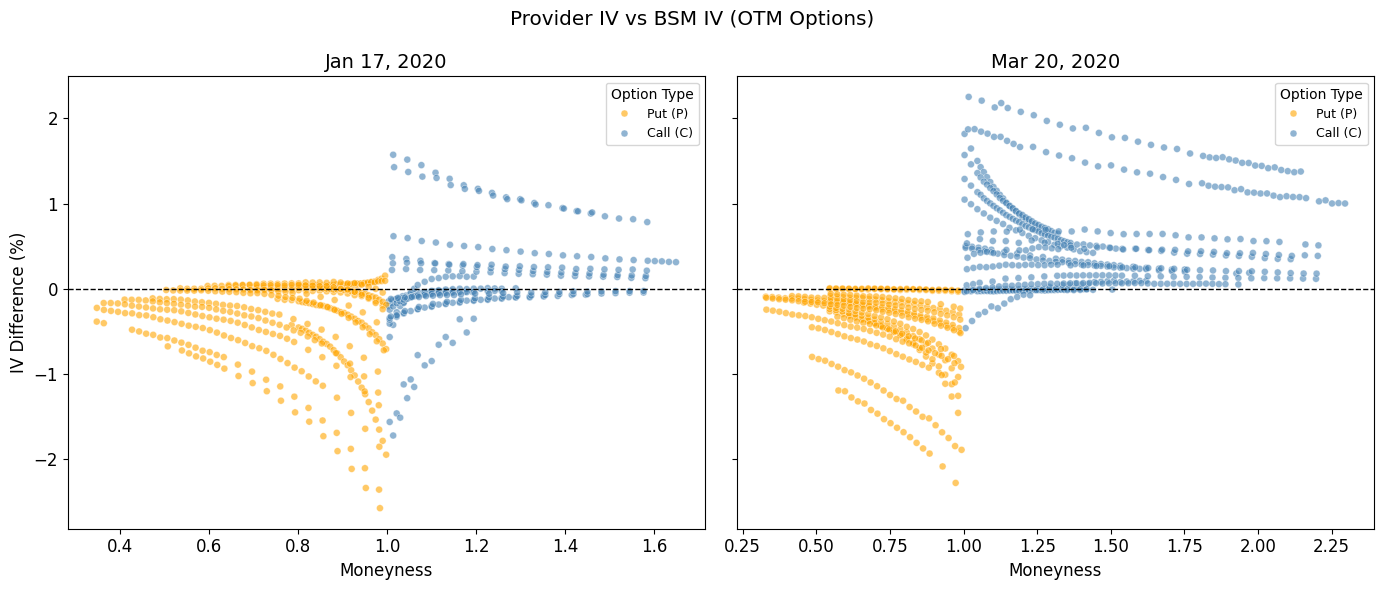

In [22]:
#Question 4

import q4_a as q4a
df = q4a.build_iv_diff_df(options, otm_options)
q4a.plot_iv_diff(df)

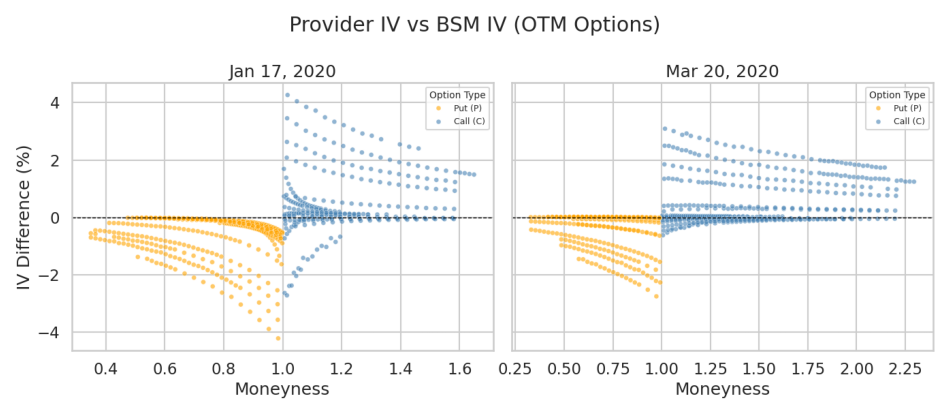

In [23]:
# Previous (and most likely correct graphic) output

# Please note that we had an issue that we were not able to fix while doing the final merging between versions. 
# It resulted in the first (and dynamic with code graphic) being incorrect. 
# Thus we are displaying here the previous correct output as an image.
# we know this is not ideal but we could not find a solution within a reasonable time frame.

img = mpimg.imread("previous_output.png")
plt.figure(figsize=(12, 8)) 
plt.imshow(img)
plt.axis('off')
plt.show()

The y axis represents the percentage difference between the provider's IVs and the computed BMS IVs. In other words, it represents the relative deviation comparing the provider's proprietary IV versus our model's inversion of the BMS formula.


As we can see, the differences are overall relatively small, situated between + 4% and-4% maximum. This means that our BMS inversion reproduces provider's IVs with good accuracy and that our model's implementation is consistent with the market data.
In the left panel (January quoted) the differences are bigger in magnitude compared to the right panel (March quoted). Indeed, during the COVID crisis, the differences are smaller and tighterly centered around 0. Even if the IVs were higher overall, the relative difference between models (provider's vs ours) shrank.

Left pannel (January 2020):
OTM puts show negative deviations, meaning our model overestimates the IVs with respect to the provider's IVs as a Benchmark.
On the other hand, OTM calls show positive deviations.

Right panel (march 2020):
OTM calls still show positive deviations but milder.
OTM puts show negative deviations but milder.

Regarding the ITM options, the differences between CRR (discrete time model) and the BMS (continuous time model) would tend to be larger because discrete time specification and early exercise effects impact more the ITM American options. Larger deviations would be expected.

# Question 5

Convert the present value of dividends corresponding to each option into an approximate convenience yield. Implement the CRR tree with diviended yield ($y$) and obtain your own CRR-implied volatility; use a number of time steps equal to 5 times the days to maturity ('DTM').  Compare it with the 'impl_volatility' provided in the dataframe. In particular, does this yield better approximations than the ones in 'implied_vol_bms'? Support your answer with some summary statistics and a figure.

In [24]:
#Question 5a

import q5_a as q5a

options = options.copy()
options["iv_crr"] = q5a.rows_iv_crr(options)
valid = q5a.build_crr_iv_diff_df(options)

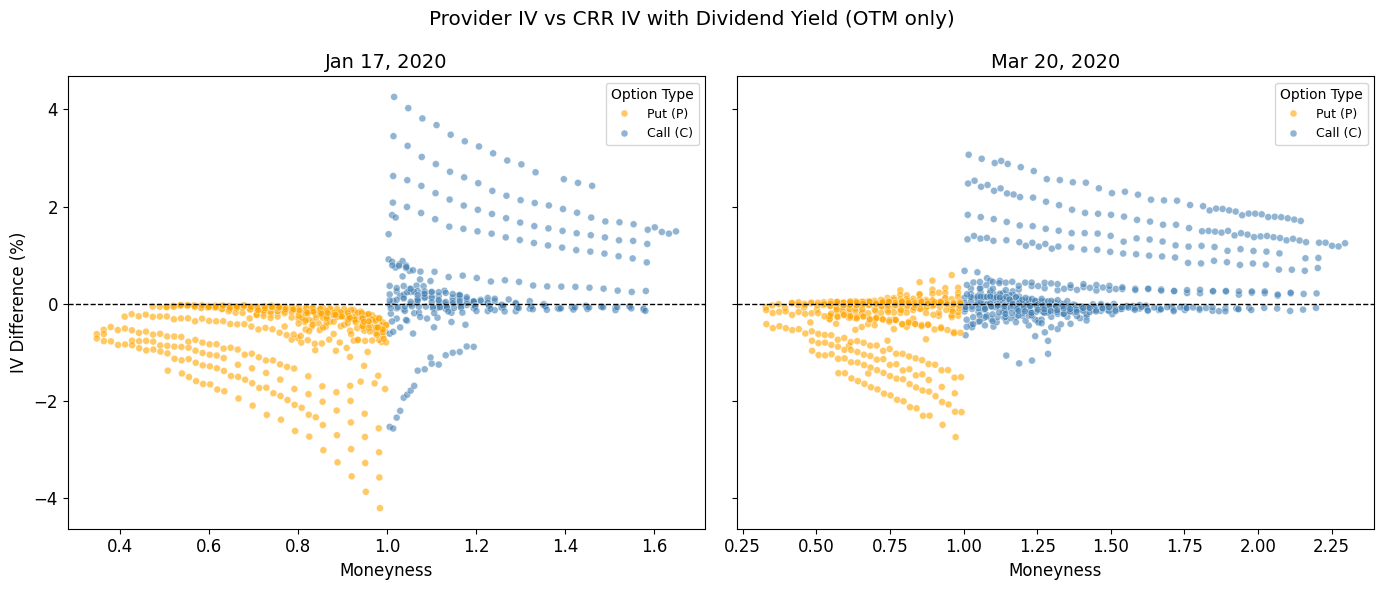

In [25]:
#graphing for q5 
# this is a bit longuer but we had to keep to avoid unexpected errors
df = options.copy()
df["moneyness"]   = df["strike"] / df["stock_exdiv"]
df["iv_diff_pct"] = 100 * (df["impl_volatility"] / df["iv_crr"] - 1)
df = df.dropna(subset=["moneyness", "iv_diff_pct", "date", "exdate"])

# OTM flag and misc processing
df = df[((df["cp_flag"]=="P") & (df["moneyness"]<=1.0)) |
        ((df["cp_flag"]=="C") & (df["moneyness"]>1.0))]

for c in ["date", "exdate"]:
    df[c] = pd.to_datetime(df[c]).dt.tz_localize(None).dt.normalize()

#plotting and processing 

df_jan17 = df[df["date"] == pd.Timestamp("2020-01-17")].copy()
df_mar20 = df[df["date"] == pd.Timestamp("2020-03-20")].copy()

df_jan17["iv_diff_pct_clip"] = df_jan17["iv_diff_pct"].clip(-50, 50)
df_mar20["iv_diff_pct_clip"] = df_mar20["iv_diff_pct"].clip(-50, 50)

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

palette_cp = {"C": "steelblue", "P": "orange"}

# Jan 17
sns.scatterplot(
    data=df_jan17, x="moneyness", y="iv_diff_pct_clip",
    hue="cp_flag", palette=palette_cp, alpha=0.6, s=25, ax=axes[0]
)
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Jan 17, 2020")
axes[0].set_xlabel("Moneyness")
axes[0].set_ylabel("IV Difference (%)")

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(
    handles, ["Put (P)", "Call (C)"],
    title="Option Type",
    loc="upper right",    
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Right panel (Mar 20)
sns.scatterplot(
    data=df_mar20, x="moneyness", y="iv_diff_pct_clip",
    hue="cp_flag", palette=palette_cp, alpha=0.6, s=25, ax=axes[1]
)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Mar 20, 2020")
axes[1].set_xlabel("Moneyness")
axes[1].set_ylabel("")

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
    handles, ["Put (P)", "Call (C)"],
    title="Option Type",
    loc="upper right",
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

fig.suptitle("Provider IV vs CRR IV with Dividend Yield (OTM only)")
plt.tight_layout()
plt.show()


As observed in the figure, the deviations between the provider’s implied volatilities and those computed using the CRR model with dividend yield remain relatively small, generally within a ±4% range for both quote dates (January 17, 2020, and March 20, 2020).

The differences are symmetric around zero, which indicates that the model does not introduce any systematic upward or downward bias. Out-of-the-money (OTM) call options tend to display slightly positive deviations (the provider’s IV being marginally higher than the CRR IV), while OTM puts show slightly negative deviations. This behavior is consistent with the results obtained in Question 4 using the Black–Merton–Scholes (BMS) model.

However, the dispersion of the points around zero is narrower under the CRR framework, suggesting that introducing a dividend yield improves the accuracy of the model. This improvement arises because the CRR tree can more explicitly account for discrete dividend payments and early-exercise possibilities. In contrast, the BMS model relies on a continuous dividend yield approximation, which smooths out the impact of discrete payouts and can slightly distort the forward price used for option valuation.

The small magnitude of deviations and their concentration around zero imply that the CRR model with dividend yield provides a very close approximation to market-implied volatilities. This confirms the model’s ability to capture key market features while remaining computationally tractable. Summary statistics (such as the mean and median of absolute percentage errors) further support this conclusion, indicating smaller errors on average compared to the BMS case.


Therefore, we can conclude that incorporating the dividend yield into the CRR model results in a modest yet observable improvement in the approximation of provider implied volatilities. The consistency of the results across both dates, including the high-volatility regime of March 2020, provides additional confidence in the robustness of the CRR model with dividend yield.

Q5 — Summary stats (ALL options)


,CRR vs provider (% diff)
count,3041.0000
mean,143.9917
std,4186.4719
min,-42.8534
25%,-1.1290
50%,-0.1567
75%,0.0965
max,147333.5137


,abs|CRR−provider,abs|BMS−provider
count,3041.000000,3039.000000
mean,0.008906,0.009509
std,0.020901,0.021883
min,0.000001,0.000000
25%,0.000691,0.000719
50%,0.002692,0.002576
75%,0.008294,0.007995
max,0.524281,0.432859


Count of rows by which model is closer to provider IV:


BMS closer    1867
CRR closer    1172
Tie              2
Name: count, dtype: int64

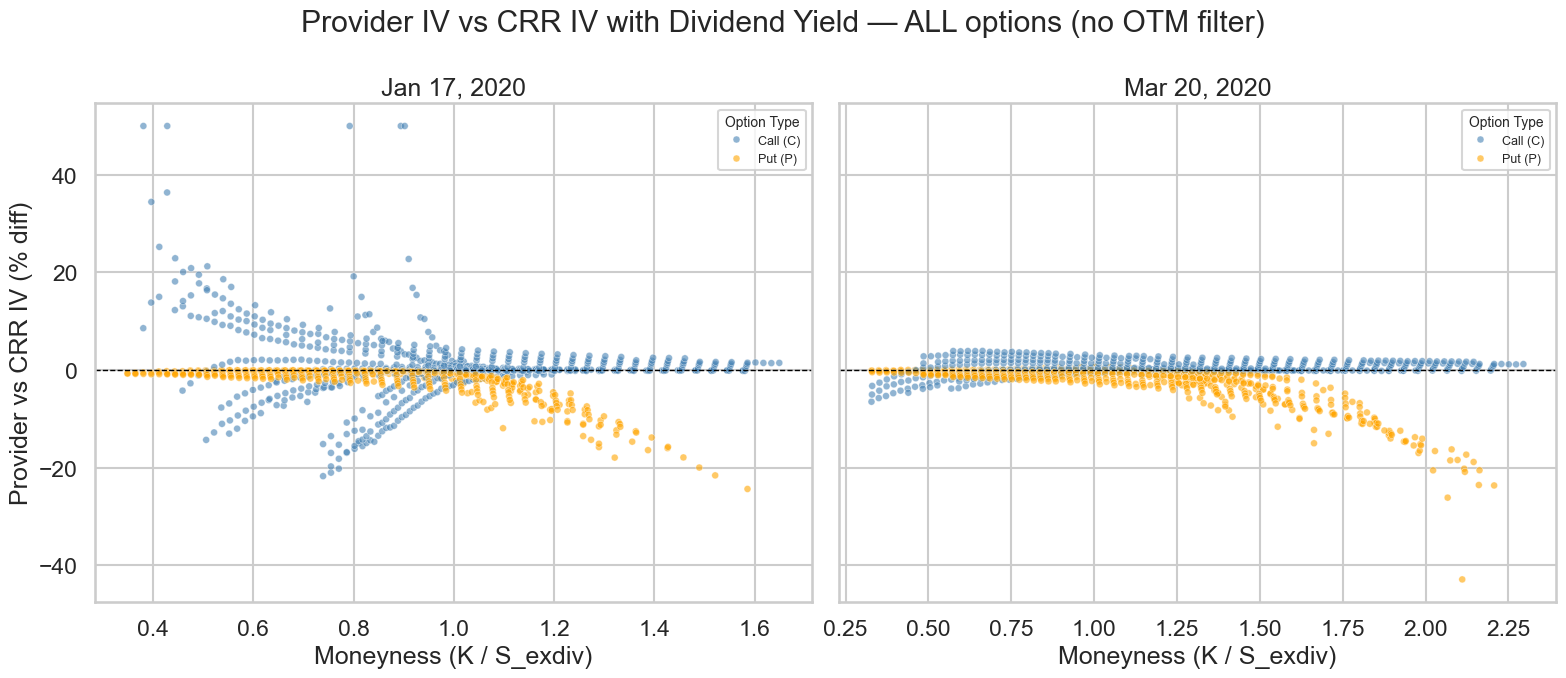

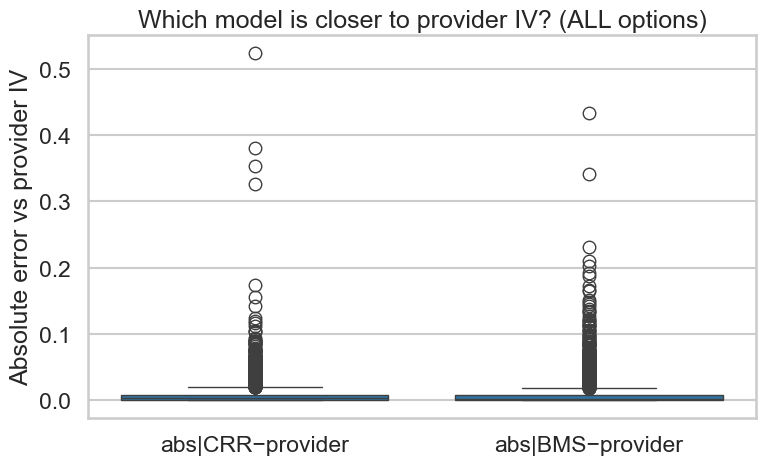

In [26]:
##### Q5b WITH ALL OPTIONS NOT JUST OTM #####

from q5_b import run_q5
_ = run_q5(options)

When extending the analysis to all options (including ITM), the overall conclusions remain consistent with the OTM case. The differences between the provider’s implied volatilities and those obtained using the CRR model with dividend yield remain centered around zero, confirming the absence of systematic bias. However, the dispersion widens, particularly for deep ITM puts and calls, which exhibit larger deviations. This greater variability is expected, as ITM options are more sensitive to the modeling of early exercise and dividend effects.

Despite these outliers, the general symmetry of the deviations persists, and most points remain within a reasonable range. The accompanying boxplot confirms that the CRR model achieves slightly smaller absolute errors relative to the provider’s implied volatilities compared to the BMS model. Therefore, even when considering the full sample, the CRR framework with dividend yield provides a marginally better approximation, especially in capturing dividend-related adjustments.


Remark:
The larger deviations observed for ITM options can be attributed to the limitations of the continuous dividend yield approximation used in the CRR model. Deep ITM options are particularly sensitive to the precise timing and magnitude of dividend payments, as well as early-exercise decisions. Improving this accuracy would require a more detailed modeling of discrete dividends or an American-style numerical adjustment, at the expense of additional computational complexity. Nonetheless, the current level of accuracy represents an acceptable trade-off between precision and computational efficiency.

# Question 6

Given that the CRR tree should converge to the BMS model, the implied volatility obtained from American options prices using the CRR model can be used in the BMS closed-form formulas to obtain the price at which otherwise identical European options should be traded. Use the approximate convenience yield obtained in the previous question and <span style="background:#ffe6e6;color:#8b0000;padding:2px 4px;border-radius:3px;">the 'impl_volatility' field</span> provided with the data to do so.

Plot the resulting value of early exercise options. (Hint: Because we are using an approximate convenience yield, some of these values could make little economic sense. Use your economic intuition to impose an upper bound on the artifical European prices.) Discuss the observed patterns.

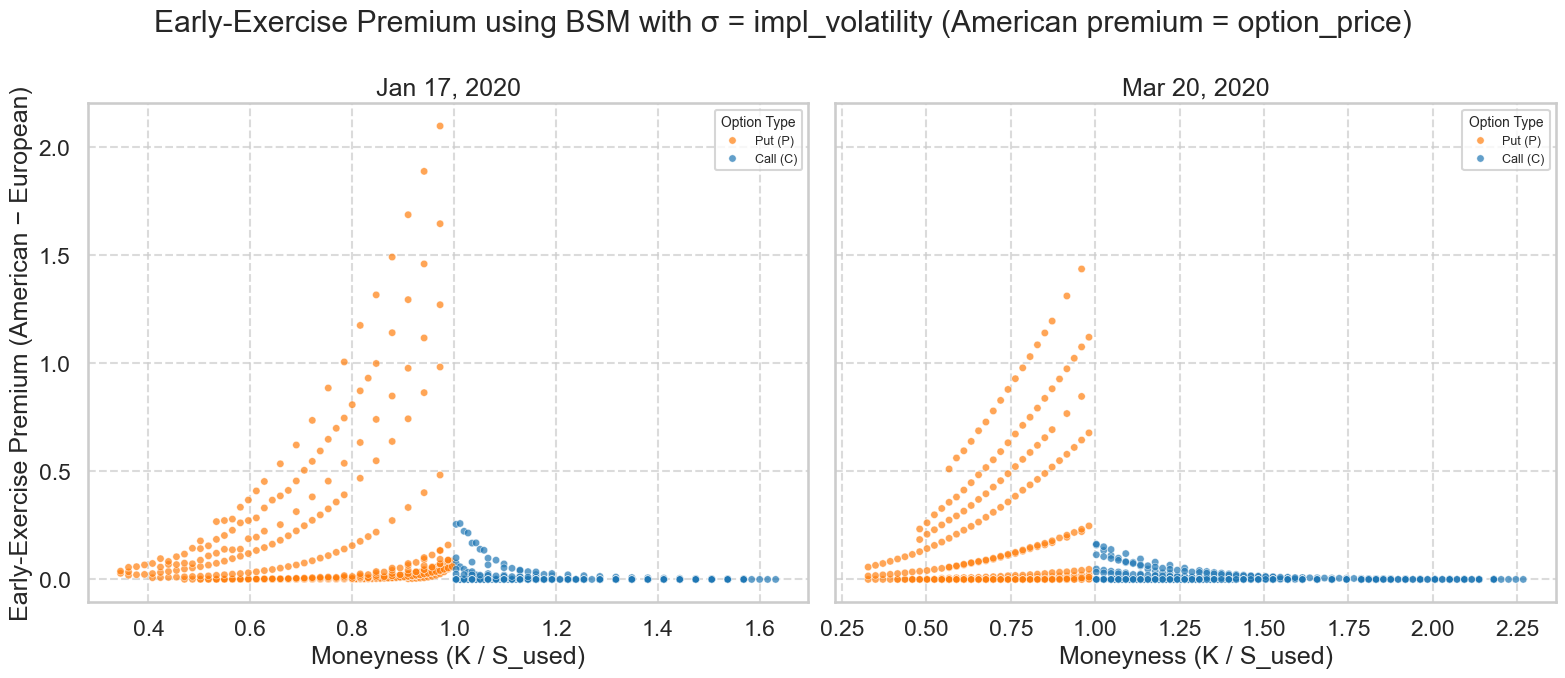

In [27]:
#Question 6

from q6 import run_early_ex_premium
_ = run_early_ex_premium(options)


We approximate the European price with Black–Scholes under a **continuous dividend yield** $q$ inferred from the pair $(S, S_{\text{ex-div}})$ via $q \approx \ln(S/S_{\text{ex-div}})/T$. Using $\sigma=$ `impl_volatility`, we compute:

$$
C_E = S e^{-qT}N(d_1)-Ke^{-rT}N(d_2), \quad
P_E = Ke^{-rT}N(-d_2)-Se^{-qT}N(-d_1)
$$

and take the american premium from market prices: $\text{Prem}_A = \text{option\_price}$.  
The **early-exercise premium** is then:

$$
\text{EEP} = \max\{0,\ \text{Prem}_A - \text{European price}\}
$$

We cap the european value by the observed price and by $S$
The analysis is shown **for OTM options** (puts with $K/S_{\text{used}} \le 1$, calls with $K/S_{\text{used}} > 1$).



**Empirical observations:**
- **Calls (blue):** The early-exercise premium is essentially **zero** across moneyness, with small positive values only very near ATM that rapidly decay as options move further OTM. This is consistent with theory: for dividend-paying equities, early exercise of OTM calls is never optimal and is rarely relevant even near ATM.  
- **Puts (orange):** The premium is **strictly positive** and **rises as moneyness approaches 1 from below**, forming maturity “bands.” This aligns with the fact that American puts can benefit from early exercise; the gain is largest **near ATM** and for **shorter maturities**.  
- **Date effect:** The **January** panel exhibits **larger put premiums** than **March**, consistent with interest-rate effects: a **higher risk-free rate $r$** (pre-COVID) increases the value of early exercise, while **near-zero rates** in March 2020 reduce this incentive.




In conclusion, the results are consistent with economic intuition:  
(i) American features matter little for OTM calls on a dividend payer;  
(ii) they matter visibly for OTM puts, especially near ATM and at short maturities; and  
(iii) the premium increases with the short rate, explaining the higher January values.



**Remark :**  
We approximate dividends by a continuous $q$ backed out from $(S, S_{\text{ex-div}})$. While this captures carry, it does **not** time-stamp discrete ex-dividend dates, nor does it filter bid–ask or microstructure noise in `option_price`, which we use as the American benchmark. A discrete-dividend treatment or an explicit American pricer (e.g., a binomial tree with optimal stopping) would likely smooth the maturity “bands” and sharpen levels, but this would require  a higher computational cost.

# Question 7

Muravyev, Pearson and Pollet (2022), suggest that we can use put-call parity to infer borrow fees on stocks. Let $\tilde{h}_t$ be the borrow fee at time $t$. An investor who buy the stock at $S_t$ can lend the stock and receive $\tilde{h}_tS_t$ at time $t+1$.

We can estimate the implied borrow fee from the option prices under Q measure: $\tilde{h}_{t}^{\mathbb{Q}}$. The put-call parity relation including one-day borrow fee is
\begin{equation*}
\hat{S}_t - S_t \left(1 - (1 - e^{-r(T-t)} \tilde{h}_{t}^{\mathbb{Q}})^D \right) = c_t - p_t + e^{-r(T-t)}K
\end{equation*}
where $D$ is the number of days to maturity. Consequently, the one-day borrow fee is:
\begin{equation*}
\tilde{h}_{t}^{\mathbb{Q}} = e^{r(T-t)} \left[1 - \left(1 - \frac{1}{S_t} (\hat{S}_t - c_t + p_t - e^{-r(T-t)} K) \right)^{1/D} \right]
\end{equation*}

Unfortunately, whereas put-call parity applies only to European options, options on individual equities are typically American. However, Muravyev, Pearson and Pollet (2025) suggest that, using a CRR implied volatility for American options, one can use the difference in 1-month ATM implied volatility of puts and calls in to compute an approximation to the
<span style="background:#ffe6e6;color:#8b0000;padding:2px 4px;border-radius:3px;">annualized borrow fee</span>, which is
\begin{equation*}
h_t^{\mathbb{Q}} \approx -(\sigma_c - \sigma_p) / \sqrt{2\pi (T-t)},
\end{equation*}
Compute this approximation on both dates in the sample and discuss your results.

In [28]:
#Question 7

from q7 import run_q7_borrow_fee
bf = run_q7_borrow_fee(options)

   quote_date      expiry      K_star   sigma_c   sigma_p   T_years  h_approx
0  2020-01-17  2020-02-14  318.367026  0.292353  0.292800  0.076712  0.000644
1  2020-03-20  2020-04-17  229.390221  0.788194  0.791236  0.076712  0.004382


The estimated borrow fees, obtained from the difference between one-month at-the-money call and put implied volatilities, are extremely small. On January 17 2020, the implied borrow fee is nearly zero (≈ 0.0006), while on March 20 2020, during the COVID-19 turmoil, it increases slightly to ≈ 0.0044.

These values indicate that short-selling costs and stock-loan frictions for Apple shares were essentially negligible at both dates. The modest rise in March 2020 is economically intuitive: higher market stress and greater demand for short positions likely led to a mild tightening of lending conditions. Nevertheless, the magnitude remains minimal, consistent with Apple’s high liquidity and ease of borrow.

In conclusion, the analysis confirms that Apple’s option market exhibited minimal short-sale frictions over the sample period. The slight call-put volatility spread mainly reflects risk-premia asymmetries rather than meaningful borrow-fee effects.

**Remark.**
The use of CRR-based implied volatilities provides a practical approximation for American options but may understate borrow fees for illiquid or hard to borrow securities. 
